In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from caveclient import CAVEclient

In [127]:
bin_width = 0.005
step_size = 0.005
y_resolution = 4  # nm per voxel

In [3]:
labels = np.array([107000, 147000, 184000, 224000, 265000]) * y_resolution / 1_000_000

In [7]:
datastack_name = "minnie65_phase3_v1"
client = CAVEclient(datastack_name)

In [8]:
nuclei = client.materialize.query_table("nucleus_detection_v0")

In [9]:
all_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")
all_cells["num_soma"] = all_cells.groupby("pt_root_id").transform("count")["valid"]
cells_by_root = all_cells.copy()
cells_by_root.index = cells_by_root.pt_root_id

In [10]:
valid_ids = set(all_cells.query("num_soma == 1").pt_root_id)

In [11]:
soma_features = pd.read_pickle("Minnie_soma_nuc_feature_model_83_1.pkl")

nuc_to_root = client.materialize.query_table("nucleus_neuron_svm")

nuc_to_root.index = nuc_to_root.id

soma_features["seg_id"] = [nuc_to_root.loc[n].pt_root_id for n in soma_features.nuc_id]
soma_features.index = soma_features.seg_id
soma_features.columns  
# size is just nucleus volume
# soma area and nucleus area closely track their respective volumes
# avg sdf is a list (of what?)

Index(['index', 'nucleus_area', 'nucleus_area_to_volume',
       'nucleus_center_mass_nm', 'nucleus_fold_area', 'nucleus_fract_fold',
       'nucleus_id', 'nucleus_volume', 'cleft_segid', 'size', 'centroid_x',
       'centroid_y', 'centroid_z', 'yr_um_translated', 'predict',
       'is_watertight', 'soma_center_mass', 'soma_volume', 'soma_area',
       'soma_area_to_volume', 'num_processes', 'avg_sdf', 'orients', 'vectors',
       'n_soma_syn', 'soma_syn_density', 'nuc_id', 'seg_id', 'soma_y',
       'soma_x', 'soma_z', 'xr', 'yr', 'nucleus_to_soma', 'sum_proc_sdf',
       'cell_type_pred_num', 'cell_type_pred', 'umapx', 'umapy', 'visible',
       'outline_color', 'outline_width', 'max_sdf'],
      dtype='object')

In [12]:
soma_features_root_ids = set(soma_features.seg_id)

In [13]:
col_cells = client.materialize.query_table("allen_v1_column_types_v2", split_positions=False)

In [14]:
exc_cells = col_cells.query("classification_system == 'aibs_coarse_excitatory'")
inh_cells = col_cells.query("classification_system == 'aibs_coarse_inhibitory'")
len(exc_cells), len(inh_cells)

(1185, 162)

In [104]:
features = ["soma_volume"] #, "n_soma_syn", "nucleus_volume", "nucleus_fract_fold", "sum_proc_sdf"]

In [15]:
auto_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")

# bounding box of the proofread column we're interested in
bbox = np.array([[ 672444., 200000., 805320.], [ 772444., 1294000., 905320.]])  # nm
resolution = np.array([4., 4., 40.])
bbox /= resolution
def in_bbox(p):
    """ returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

auto_col_cells = auto_cells[auto_cells.pt_position.apply(in_bbox)]
for feature in features:
    auto_col_cells[feature] = [(soma_features.loc[r][feature] if r in soma_features_root_ids and type(soma_features.loc[r][feature]) is not pd.Series else np.nan)
                           for r in auto_col_cells.pt_root_id]
auto_exc_cells = auto_col_cells.query("classification_system == 'aibs_coarse_excitatory'")
auto_inh_cells = auto_col_cells.query("classification_system == 'aibs_coarse_inhibitory'")

C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

## Synapses in the center of the column

In [99]:
syn_bbox = bbox.copy()
sample_width = 10_000  # nm square cross section
x_vx_width = sample_width / resolution[0]
z_vx_width = sample_width / resolution[2]
syn_bbox[0, 0] = bbox[0, 0] + (bbox[1, 0] - bbox[0, 0]) / 2
syn_bbox[1, 0] = syn_bbox[0, 0] + x_vx_width
syn_bbox[0, 2] = bbox[0, 2] + (bbox[1, 2] - bbox[0, 2]) / 2
syn_bbox[1, 2] = syn_bbox[0, 2] + z_vx_width
syn_bbox, bbox

(array([[180611.,  50000.,  21383.],
        [183111., 323500.,  21633.]]),
 array([[168111.,  50000.,  20133.],
        [193111., 323500.,  22633.]]))

In [100]:
synapses = client.materialize.synapse_query(bounding_box=syn_bbox, bounding_box_column="ctr_pt_position", split_positions=True)

In [102]:
synapses["pre_type"] = [(cells_by_root.loc[root].cell_type if root in valid_ids else "N/A") for root in synapses.pre_pt_root_id]
synapses["post_type"] = [(cells_by_root.loc[root].cell_type if root in valid_ids else "N/A") for root in synapses.post_pt_root_id]
syn_depths = synapses.ctr_pt_position_y.values * y_resolution / 1_000_000
syn_depths_by_pre = dict((t, []) for t in cell_types)
syn_depths_by_post = dict((t, []) for t in cell_types)
for i in synapses.index:
    # pre
    syn = synapses.loc[i]
    if syn.pre_type in ctype_to_layer.keys():
        syn_depths_by_pre["exc"].append(syn.ctr_pt_position_y * y_resolution / 1_000_000)
    elif syn.pre_type in syn_depths_by_pre.keys():
        syn_depths_by_pre[syn.pre_type].append(syn.ctr_pt_position_y * y_resolution / 1_000_000)
    
    # post
    if syn.post_type in ctype_to_layer.keys():
        syn_depths_by_post["exc"].append(syn.ctr_pt_position_y * y_resolution / 1_000_000)
    elif syn.post_type in syn_depths_by_post.keys():
        syn_depths_by_post[syn.post_type].append(syn.ctr_pt_position_y * y_resolution / 1_000_000)
for t in syn_depths_by_pre:
    syn_depths_by_pre[t] = np.array(syn_depths_by_pre[t])
for t in syn_depths_by_post:
    syn_depths_by_post[t] = np.array(syn_depths_by_post[t])

synapses

,id,valid,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_position_x,post_pt_position_y,post_pt_position_z,post_pt_supervoxel_id,post_pt_root_id,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_type,post_type
0,165543171,t,182532,162148,21401,89874493577062805,864691135406145778,182502,162178,21409,89874493577078337,864691136602049489,182514,162176,21406,3048,N/A,MC
1,168640659,t,182066,205398,21608,89809897335697882,864691134554732752,181954,205386,21608,89809897335699907,864691136194449740,182006,205366,21614,3036,N/A,5P_IT
2,166909980,t,182480,172396,21469,89875867966672084,864691135373530824,182458,172306,21473,89875867966673020,864691135354901711,182514,172320,21476,19024,N/A,4P
3,165039980,t,182186,134386,21627,89800414047943105,864691135507506884,182136,134334,21636,89800345328466671,864691135771743563,182171,134354,21627,9744,N/A,BC
4,166843764,t,182448,169688,21406,89875524369248710,864691135489538756,182516,169658,21408,89875455649809129,864691135753571277,182490,169652,21406,3052,N/A,4P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54133,165092240,t,182286,87050,21431,89794023069395484,864691134974174632,182276,86932,21425,89794023069392698,864691133617329487,182278,87002,21431,204,N/A,N/A
54134,165628644,t,182960,125948,21574,89939983305122289,864691136617397211,182866,125894,21571,89939983305119255,864691133599719048,182922,125880,21573,2288,N/A,N/A
54135,169879523,t,182732,246282,21631,89885763638045264,864691135162274349,182632,246276,21628,89885763638040698,864691135602850244,182702,246248,21632,3036,BPC,N/A
54136,170162076,t,182254,240632,21384,89814638912801480,864691135485446130,182324,240626,21395,89885007656944904,864691135730428857,182284,240616,21388,268,N/A,N/A


In [155]:
cell_types = ["exc", "BC", "BPC", "MC", "NGC"]
ctype_to_layer = {"23P": "23",
                 "4P": "4",
                 "5P_PT": "5",
                 "5P_IT": "5",
                 "5P_NP": "5",
                 "6P": "6",
                 "6CT": "6",
                 "6IT": "6"}

In [156]:
# cross sectional area to be layered
xarea = resolution[0] * resolution[2] * (bbox[1][0] - bbox[0][0]) * (bbox[1][2] - bbox[0][2]) / 1_000_000 ** 2

In [157]:
# min is pia border (L1) and max is white matter border (L6)
min_y = min(pt[1] * y_resolution / 1_000_000 for pt in auto_col_cells.pt_position)
max_y = max(pt[1] * y_resolution / 1_000_000 for pt in auto_col_cells.pt_position)
min_y, max_y

(0.358016, 1.086656)

In [158]:
auto_col_cells = auto_col_cells.sort_values(axis="index", by="pt_position", key=lambda xs: pd.Series([x[1] for x in xs]))

def get_cutoff_idx(df, y, prev_cutoff_idx, position_col="pt_position"):
    """efficiently find the rows deeper than the row at prev_cutoff_idx but shallower than y
    in a sorted dataframe of pt_positions"""
    # first index where pt_position[1] is greater than curr_y + bin_width 
    i = prev_cutoff_idx
    while df.iloc[i][position_col][1] * y_resolution / 1_000_000 < y:
        i += 1
        if i >= len(df):
            return i
    return i  # new_cutoff_idx

In [159]:
exc_soma_densities = []
inh_soma_densities = []
synapse_densities = []
# syn_densities_by_pre = dict((t, []) for t in syn_depths_by_pre.keys())
# syn_densities_by_post = dict((t, []) for t in syn_depths_by_post.keys())
p_type = dict((t, []) for t in ["23", "4", "5", "6"])
p_inh_subclass = dict((t, []) for t in ["BC", "BPC", "MC", "NGC"])
exc_soma_features_by_depth = dict((f, []) for f in features)
inh_soma_features_by_depth = dict((f, []) for f in features)
soma_features_by_depth = dict((f, []) for f in features)
bin_centers = []

curr_y = min_y
prev_cutoff_idx = 0
while curr_y < max_y:
    bin_centers.append(curr_y + bin_width // 2)
    # first index where pt_position[1] is greater than curr_y + bin_width 
    cutoff_idx = get_cutoff_idx(auto_col_cells, curr_y + bin_width, prev_cutoff_idx)
    
    current_cells = auto_col_cells.iloc[prev_cutoff_idx:cutoff_idx]
    current_exc_cells = current_cells.query("classification_system == 'aibs_coarse_excitatory'")
    current_inh_cells = current_cells.query("classification_system == 'aibs_coarse_inhibitory'")
    
    for f in features:
        soma_features_by_depth[f].append(current_cells[f].mean())
        exc_soma_features_by_depth[f].append(current_exc_cells[f].mean())
        inh_soma_features_by_depth[f].append(current_inh_cells[f].mean())
                          
    for t in p_type:
        p_type[t].append(0)
    for i in current_exc_cells.index:
        if current_exc_cells.loc[i].cell_type != "Unsure":
            p_type[ctype_to_layer[current_exc_cells.loc[i].cell_type]][-1] += 1 / len(current_exc_cells) if len(current_exc_cells) > 0 else np.nan
    exc_soma_densities.append(len(current_exc_cells))
    
    inh_soma_densities.append(len(current_inh_cells))
    for t in p_inh_subclass:
        p_inh_subclass[t].append(0)
    for i in current_inh_cells.index:
        if current_inh_cells.loc[i].cell_type != "Unsure":
            p_inh_subclass[current_inh_cells.loc[i].cell_type][-1] += 1 / len(current_inh_cells) if len(current_inh_cells) > 0 else np.nan
            
    # # this is still slow
    # synapse_densities.append(sum((curr_y <= syn_depths) & (syn_depths < curr_y + bin_width)))
    # for t in syn_densities_by_pre.keys():
    #     syn_densities_by_pre[t].append(sum((curr_y <= syn_depths_by_pre[t]) & (syn_depths_by_pre[t] < curr_y + bin_width)))
    # for t in syn_densities_by_post.keys():
    #     syn_densities_by_post[t].append(sum((curr_y <= syn_depths_by_post[t]) & (syn_depths_by_post[t] < curr_y + bin_width)))
    
    curr_y += step_size
    prev_cutoff_idx = cutoff_idx
bin_centers = np.array(bin_centers)
exc_soma_densities = np.array(exc_soma_densities, dtype=float) / (bin_width * xarea)  # per mm^3
inh_soma_densities = np.array(inh_soma_densities, dtype=float) / (bin_width * xarea)
# synapse_densities = np.array(synapse_densities, dtype=float) / (bin_width * xarea)
for t in p_type:
    p_type[t] = np.array(p_type[t])
for t in p_inh_subclass:
    p_inh_subclass[t] = np.array(p_inh_subclass[t])
# for t in syn_densities_by_pre:
#     syn_densities_by_pre[t] = np.array(syn_densities_by_pre[t]) / (bin_width * xarea)
# for t in syn_depths_by_post:
#     syn_densities_by_post[t] = np.array(syn_densities_by_post[t]) / (bin_width * xarea)

L1: low soma density
L2: high soma density
L3: med soma density
L4: high soma density
L5: med soma density, large soma
L6: medhigh soma density

L1-L2	107000

L3-L4	147000
L4-L5	184000
L5-L6	224000
L6-WM	265000

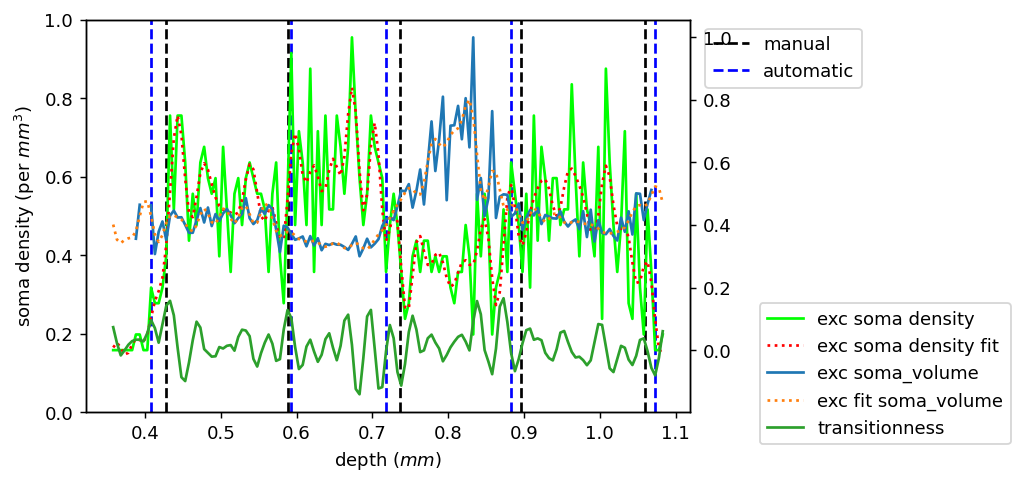

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=130)
ax2 = ax.twinx()
# ax.plot(bin_centers, inh_soma_densities, c="indigo", label="inh soma density")
ax2.plot(bin_centers, exc_soma_densities / np.nanmax(exc_soma_densities), c="lime", label="exc soma density")
ax2.plot(bin_centers, normalized_smooth_exc_densities, ":r", label="exc soma density fit")
# ax.plot(bin_centers, smooth_exc_deriv * 5, ":r", label="exc fit deriv")
for f in features:
    ax2.plot(bin_centers, exc_soma_features_by_depth[f] / np.nanmax(exc_soma_features_by_depth[f]), linestyle="-", label="exc " + f)
    ax2.plot(bin_centers, normalized_smooth_exc_features[f], linestyle=":", label="exc fit " + f)
#     ax2.plot(bin_centers, inh_soma_features_by_depth[f] / max(inh_soma_features_by_depth[f]), linestyle="-", label="inh " + f)
#     ax2.plot(bin_centers, soma_features_by_depth[f] / max(soma_features_by_depth[f]), linestyle="-", label=f)

# ax.plot(bin_centers, synapse_densities, label="syn")
# for t in syn_densities_by_pre:
#     ax2.plot(bin_centers, syn_densities_by_pre[t], label=t)
# for t in syn_densities_by_post:
#     ax2.plot(bin_centers, syn_densities_by_post[t], label=t)
    
# for t in p_type:
#     ax2.plot(bin_centers, p_type[t])
# for c in p_inh_subclass:
#     ax2.plot(bin_centers, p_inh_subclass[c], label=c)
# cells_to_plot = col_cells
# indices_to_plot = np.random.choice(cells_to_plot.index, 500)
# for cell in indices_to_plot:
#     if cells_to_plot.loc[cell].cell_type == "23P":
#         ax2.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="red", alpha=0.1)

#     if cells_to_plot.loc[cell].cell_type == "4P":
#         ax2.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="y", alpha=0.1)

#     if cells_to_plot.loc[cell].cell_type.startswith("5P"):
#         ax2.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="orange", alpha=0.1)

#     if cells_to_plot.loc[cell].cell_type in ["6P", "6IT", "6CT"]:
#         ax2.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="green", alpha=0.1)

#     if cells_to_plot.loc[cell].cell_type.startswith("Unsure"):
#         ax2.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="brown", alpha=0.1)

ax.axvline(labels[0], linestyle="--", color="k", label="manual")
for lab in labels[1:]:
    ax.axvline(lab, linestyle="--", color="k")
ax.axvline(bounds[0], linestyle="--", color="blue", label="automatic")
for bound in bounds[1:]:
    ax.axvline(bound, linestyle="--", color="blue")
plt.plot(bin_centers, transitionness * 5, label="transitionness")
ax.legend(bbox_to_anchor=[1.01, 1])
ax2.legend(bbox_to_anchor=[1.1, 0.3])
ax.set_xlabel("depth ($mm$)")
ax.set_ylabel("soma density (per $mm^{3}$)")
# ax2.set_ylabel("synapse density (per $mm^3$)")
plt.show()

# Hidden Markov Model implementation

In [161]:
from hmmlearn import hmm

In [205]:
hmm.GaussianHMM?

In [206]:
model = hmm.GaussianHMM(n_components=6, covariance_type="diag", init_params="", params="mc")
# the model starts in the first state, and there is 0 probability of starting elsewhere
model.startprob_ = np.zeros(model.n_components)
model.startprob_[0] = 1
p = 0.04
transition_probs = np.full(model.n_components - 1, p)
stay_probs = np.full(model.n_components, 1-p)
transition_probs[0] = 0.5  # pia is small
stay_probs[0] = 0.5
stay_probs[-1] = 1  # nothing deeper than white matter
model.transmat_ = np.diag(stay_probs) + np.diag(transition_probs, k=1)
model.transmat_

array([[0.5 , 0.5 , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.96, 0.04, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.96, 0.04, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.96, 0.04, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.96, 0.04],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

In [207]:
# initialize means and variances
model.means_ = np.array([[0], [0.6], [0.7], [0.4], [0.5], [0]])  
model.covars_ = np.full((model.n_components, 1), 0.1)
observables, hidden_states = model.sample(101)

In [208]:
varis = (exc_soma_densities / np.max(exc_soma_densities)).reshape(-1, 1)

In [209]:
model.transmat_

array([[0.5 , 0.5 , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.96, 0.04, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.96, 0.04, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.96, 0.04, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.96, 0.04],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

In [211]:
prev_score = 0
score = model.score(varis)
while abs(score - prev_score) > 0.001:
    model.fit(varis)
    prev_score = score
    score = model.score(varis)
    print(score, model.means_)
    model.means_[[0, -1]] = 0
    print("zeroed", model.score(varis))

52.97813915932368 [[0.04883582]
 [0.49581308]
 [0.58442791]
 [0.28832533]
 [0.46801924]
 [0.17696507]]
zeroed 48.18312563392061
57.56997850381445 [[0.01001418]
 [0.46728053]
 [0.58644018]
 [0.28845172]
 [0.46813645]
 [0.17706426]]
zeroed 54.26970292037396
57.57068363282176 [[0.0100142 ]
 [0.46727711]
 [0.58623984]
 [0.28832692]
 [0.46777677]
 [0.17672713]]
zeroed 54.28087373225382


In [212]:
layers = model.predict(varis).tolist()

In [216]:
str(layers)

'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5]'

In [214]:
bounds = []
for i in range(1, model.n_components):
    idx = layers.index(i)
    bounds.append(bin_centers[idx])
    print(bin_centers[idx])
bounds = np.array(bounds)

0.40801600000000005
0.5930160000000002
0.7180160000000003
0.8830160000000005
1.073015999999999


# Sum of magnitudes of fft-smoothed derivatives

In [170]:
from scipy import fft

In [171]:
freq_cutoff = 0.2
cleaned = np.array(exc_soma_densities)
mask = np.isfinite(cleaned)
cleaned = np.interp(np.arange(len(cleaned)), np.arange(len(cleaned))[mask], cleaned[mask])
cleaned /= cleaned.max()
e_fft = fft.fft(cleaned)
freqs = fft.fftfreq(len(exc_soma_densities))
mask = abs(freqs) < freq_cutoff
e_fft *= mask  # remove high frequency content (details/noise)
e_fft_prime = e_fft * 1j * freqs  # take (spectral) derivative
normalized_smooth_exc_densities = np.real(fft.ifft(e_fft))
smooth_exc_soma_densities_deriv = np.real(fft.ifft(e_fft_prime))

normalized_smooth_exc_features = dict() 
smooth_exc_feature_derivs = dict()
for f in features:
    cleaned = np.array(exc_soma_features_by_depth[f])
    mask = np.isfinite(cleaned)
    cleaned = np.interp(np.arange(len(cleaned)), np.arange(len(cleaned))[mask], cleaned[mask])
    cleaned /= cleaned.max()
    e_fft = fft.fft(cleaned)
    freqs = fft.fftfreq(len(cleaned))
    mask = abs(freqs) < freq_cutoff
    e_fft *= mask  # remove high frequency content (details/noise)
    e_fft_prime = e_fft * 1j * freqs  # take (spectral) derivative
    normalized_smooth_exc_features[f] = np.real(fft.ifft(e_fft))
    smooth_exc_feature_derivs[f] = np.real(fft.ifft(e_fft_prime))

In [172]:
exc_soma_features_by_depth

{'soma_volume': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  700973745875.5697,
  914474231362.6543,
  nan,
  nan,
  911566265857.1487,
  604510877899.3575,
  744860094935.7012,
  809454404675.1868,
  693580802007.0685,
  846349015231.9507,
  877882191290.6494,
  834317400618.1305,
  835885617606.4106,
  787975765325.1364,
  738161927369.7578,
  738387402959.2815,
  818825406213.1057,
  893636939231.5874,
  803190121287.9177,
  897066091553.288,
  780612004215.0476,
  856008055134.022,
  812325731764.7339,
  860091152303.4946,
  888212106399.4254,
  848142691143.679,
  798467372988.1735,
  830863678823.8469,
  857399167801.1206,
  956086572773.0874,
  830120061510.7245,
  793351260372.1598,
  817385549706.3584,
  892602479109.5332,
  856121277602.2252,
  912449985524.1272,
  886544321897.0387,
  758656264427.3007,
  617148357862.1167,
  782797049775.6631,
  772075866968.8341,
  730179410166.9943,
  694092904239.8616,
  702763865598.8494,
  714853655268.3368,
  653042512201.9097,
  717313

In [173]:
transitionness = sum(np.abs(smooth_exc_feature_derivs[f]) for f in features) + smooth_exc_soma_densities_deriv

In [174]:
len(transitionness)

146

# Boundary finding
Ideas:
Threshholds, except there is a weight to match these widths (L1-L2 boundary at 0.4mm, L2/3 0.18mm wide, L4 0.17mm wide

## Nuno's Find the halfway points between the local extrema (but what about 3/4?)
Use the fft-smoothed version of the data

In [121]:
bounds = np.empty(labels.shape)

In [122]:
def find_local_extrema(x):
    """specifically for the task of layer segmentation."""
    assert x[1] > x[0]
    assert x[-2] > x[-1]
    maxima_idxs = []
    maxima = []
    minima_idxs = [0]
    minima = [x[0]]
    for i in range(1, len(x) - 1):
        if x[i-1] < x[i] and x[i] > x[i+1]:
            maxima_idxs.append(i)
            maxima.append(x[i])
        if x[i-1] > x[i] and x[i] < x[i+1]:
            minima_idxs.append(i)
            minima.append(x[i])
    minima_idxs.append(len(x) - 1)
    minima.append(x[-1])
    assert len(maxima_idxs) == 3
    assert len(minima_idxs) == 4
    return maxima_idxs, minima_idxs, maxima, minima

In [123]:
maxima_idxs, minima_idxs, maxima, minima = find_local_extrema(smooth_exc_densities)

AssertionError: 

In [82]:
thresh = (minima[0] + maxima[0]) /  2
for i in range(minima_idxs[0] + 1, maxima_idxs[0]):
    if smooth_exc_densities[i] > thresh > smooth_exc_densities[i - 1]:
        bounds[0] = bin_centers[i - 1] + step_size * (thresh - smooth_exc_densities[i - 1]) / (smooth_exc_densities[i] - smooth_exc_densities[i - 1])  # linear interpolate
        
thresh = (minima[1] + maxima[1]) /  2  # NOTE: we skip one threshold (perhaps L2-L3 boundary?)
for i in range(minima_idxs[1] + 1, maxima_idxs[1]):
    if smooth_exc_densities[i] > thresh > smooth_exc_densities[i - 1]:
        bounds[1] = bin_centers[i - 1] + step_size * (thresh - smooth_exc_densities[i - 1]) / (smooth_exc_densities[i] - smooth_exc_densities[i - 1])
        
thresh = (minima[2] + maxima[1]) /  2
for i in range(maxima_idxs[1] + 1, minima_idxs[2]):
    if smooth_exc_densities[i] < thresh < smooth_exc_densities[i - 1]:
        bounds[2] = bin_centers[i - 1] + step_size * (thresh - smooth_exc_densities[i - 1]) / (smooth_exc_densities[i] - smooth_exc_densities[i - 1])
        
thresh = (minima[2] + maxima[2]) /  2
for i in range(minima_idxs[2] + 1, maxima_idxs[2]):
    if smooth_exc_densities[i] > thresh > smooth_exc_densities[i - 1]:
        bounds[3] = bin_centers[i - 1] + step_size * (thresh - smooth_exc_densities[i - 1]) / (smooth_exc_densities[i] - smooth_exc_densities[i - 1])
        
thresh = (minima[3] + maxima[2]) /  2
for i in range(maxima_idxs[2] + 1, minima_idxs[3]):
    if smooth_exc_densities[i] < thresh < smooth_exc_densities[i - 1]:
        bounds[4] = bin_centers[i - 1] + step_size * (thresh - smooth_exc_densities[i - 1]) / (smooth_exc_densities[i] - smooth_exc_densities[i - 1])

C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


IndexError: index 37 is out of bounds for axis 0 with size 37

## Weighted combination of depth, excitatory density, and cell type
It turns out cell type was heavily determined by depth, so this method is not very good

In [50]:
bounds = np.empty(labels.shape)

In [51]:
def gaussian(x, center=0, size=1):
    """ gaussian with max=1"""
    return np.exp(-(x - center)**2 / (2*size**2))

def decreasing_mask(x):
    """ Finds the indices where x[i] > x[i-1], and returns a boolean array of the same shape.
    The first index of the result takes the same value as the second.
    """
    if len(x) < 2:
        return np.full(len(x), False)
    result = [x[i-1] > x[i] for i in range(1, len(x))]
    result = [result[0]] + result
    return np.array(result)


In [52]:
# L1-L2 boundary
depth = 0.4 # mm
exc_density_thresh = 150_000  # somas per micron depth (in a 0.100 x 0.100 mm area)
# the L1-L2 boundary is not going to be deeper than 0.7 mm
# and must be during increasing density portion
possible_idxs = np.nonzero((bin_centers < 0.7) \
                & ~decreasing_mask(exc_soma_densities))[0]  
quality = gaussian(exc_soma_densities[possible_idxs], center=exc_density_thresh, size=20_000) \
          * gaussian(bin_centers[possible_idxs], center=depth, size=0.08)
bounds[0] = bin_centers[possible_idxs[np.argmax(quality)]]

In [53]:
np.nonzero((bin_centers < 0.7) \
                & ~decreasing_mask(exc_soma_densities))[0]  

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 12, 14, 15, 16, 17, 19, 20, 21,
       22, 23, 25, 26, 27, 28, 30, 31], dtype=int64)

In [16]:
# plt.plot(bin_centers[possible_idxs], gaussian(exc_soma_densities[possible_idxs], center=exc_density_thresh, size=20_000))
# plt.plot(bin_centers[possible_idxs], gaussian(bin_centers[possible_idxs], center=depth, size=0.08))
# plt.plot(bin_centers[possible_idxs], quality)

In [105]:
# L3-L4 boundary
depth = bounds[0] + 0.18
layer = "23"
# and must be during increasing density portion  (I know index 0 is messed up--it shouldn't matter)
possible_idxs = np.nonzero(decreasing_mask(p_type[layer]))[0]
quality = gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1) \
          * gaussian(bin_centers[possible_idxs], center=depth, size=0.08)
bounds[1] = bin_centers[possible_idxs[np.argmax(quality)]]

In [17]:
# plt.plot(bin_centers[possible_idxs], gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1))
# plt.plot(bin_centers[possible_idxs], gaussian(bin_centers[possible_idxs], center=depth, size=0.08))
# # plt.plot(bin_centers, decreasing_mask(p_type[layer]))

In [107]:
# L4-L5 boundary
depth = bounds[1] + 0.17
exc_density_cutoff = 170_000
layer = "4"
# and must be during increasing density portion  (I know index 0 is messed up--it shouldn't matter)
possible_idxs = np.nonzero(decreasing_mask(p_type[layer])
                          & decreasing_mask(exc_soma_densities))[0]
quality = gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1) \
          * gaussian(bin_centers[possible_idxs], center=depth, size=0.08) \
          * gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000)
bounds[2] = bin_centers[possible_idxs[np.argmax(quality)]]

In [18]:
# plt.plot(bin_centers[possible_idxs], gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1))
# plt.plot(bin_centers[possible_idxs], gaussian(bin_centers[possible_idxs], center=depth, size=0.08))
# plt.plot(bin_centers[possible_idxs], gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000))

In [111]:
# L5-L6 boundary
depth = bounds[2] + 0.15
exc_density_cutoff = 160_000
layer = "5"
# and must be during increasing density portion  (I know index 0 is messed up--it shouldn't matter)
possible_idxs = np.nonzero(decreasing_mask(p_type[layer])
                          & ~decreasing_mask(exc_soma_densities))[0]
quality = gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1) \
          * gaussian(bin_centers[possible_idxs], center=depth, size=0.08) \
          * gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000)
bounds[3] = bin_centers[possible_idxs[np.argmax(quality)]]

In [19]:
# plt.plot(bin_centers[possible_idxs], gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1))
# plt.plot(bin_centers[possible_idxs], gaussian(bin_centers[possible_idxs], center=depth, size=0.08))
# plt.plot(bin_centers[possible_idxs], gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000))

In [123]:
# L6-WM boundary
depth = bounds[3] + 0.17
exc_density_cutoff = 130_000
# and must be during increasing density portion  (I know index 0 is messed up--it shouldn't matter)
possible_idxs = np.nonzero((bin_centers > 0.95) & decreasing_mask(exc_soma_densities))[0]
quality = gaussian(bin_centers[possible_idxs], center=depth, size=0.08) \
          * gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000)
bounds[4] = bin_centers[possible_idxs[np.argmax(quality)]]

In [20]:
# plt.plot(bin_centers[possible_idxs], gaussian(bin_centers[possible_idxs], center=depth, size=0.08))
# plt.plot(bin_centers[possible_idxs], gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000))
# # plt.plot(bin_centers[possible_idxs], quality)

ValueError: cannot convert float NaN to integer

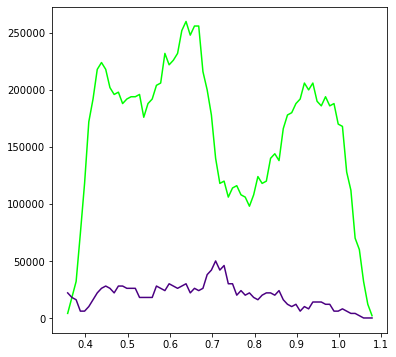

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(bin_centers, exc_soma_densities, c="lime", label="exc")
ax.plot(bin_centers, inh_soma_densities, c="indigo", label="inh")
ax.plot(bin_centers, avg_volumes * max(exc_soma_densities) / max(avg_volumes), label=f"avg nuc volume ($\mu m * {round(max(avg_volumes) / max(exc_soma_densities))}$)")
for t in p_type:
    ax.plot(bin_centers, p_type[t] * 100_000)

cells_to_plot = col_cells
indices_to_plot = np.random.choice(cells_to_plot.index, 500)
for cell in indices_to_plot:
    if cells_to_plot.loc[cell].cell_type == "23P":
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="red", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type == "4P":
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="y", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type.startswith("5P"):
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="orange", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type in ["6P", "6IT", "6CT"]:
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="green", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type.startswith("Unsure"):
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="brown", alpha=0.1)
        
for bound in bounds:
    ax.axvline(bound, linestyle="--", color="k")
ax.legend()
plt.show()

In [128]:
exc_soma_densities

array([  4000.,  18000.,  32000.,  74000., 118000., 172000., 192000.,
       218000., 224000., 218000., 202000., 196000., 198000., 188000.,
       192000., 194000., 194000., 196000., 176000., 188000., 192000.,
       204000., 206000., 232000., 222000., 226000., 232000., 252000.,
       260000., 248000., 256000., 256000., 216000., 200000., 178000.,
       140000., 118000., 120000., 106000., 114000., 116000., 108000.,
       106000.,  98000., 108000., 124000., 118000., 120000., 140000.,
       144000., 138000., 166000., 178000., 180000., 188000., 192000.,
       206000., 200000., 206000., 190000., 186000., 194000., 186000.,
       188000., 170000., 168000., 128000., 112000.,  70000.,  60000.,
        32000.,  12000.,   2000.])

In [126]:
sum(auto_cells.cell_type == "BC")

3009

No handles with labels found to put in legend.


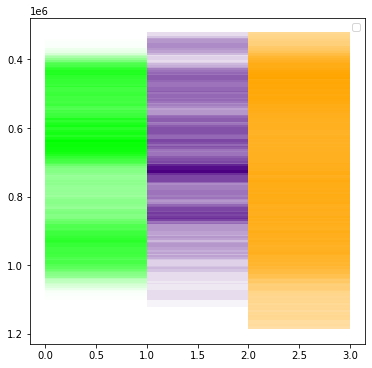

In [113]:
# todo fill with alpha = density
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(len(bin_centers)):
        bin_start, bin_end = bin_centers[i] - step_size // 2, bin_centers[i] + step_size // 2
        ax.fill_between([0, 1], [bin_start]*2, [bin_end]*2, alpha=exc_soma_densities[i] / max(exc_soma_densities), color="lime", edgecolor=None)
        ax.fill_between([1, 2], [bin_start]*2, [bin_end]*2, alpha=inh_soma_densities[i] / max(inh_soma_densities), color="indigo", edgecolor=None)
        ax.fill_between([2, 3], [bin_start]*2, [bin_end]*2, alpha=avg_volumes[i] / max(avg_volumes), color="orange", edgecolor=None)
    
ax.invert_yaxis()
ax.legend()
plt.show()

53552

## Ideas:
Use query_table(filter_spatial) to get synapse density too (and stratify by cell type)

Use inhibitory cell subclass densities (do these use depth info? yes, so don't)

Use *excitatory* soma features (they're much less noisy than inhibitory/combined features) and look for significant and steep changes in these features with depth by using the fft-smoothed version of each feature (as a function of depth) and then take its derivative (in fourier domain). The magnitude of the derivative of the smoothed function indicates how much of a transition zone it is according to that feature, and if we take the product of these derivative magnitudes we should see peaks at the layer borders.

In [103]:
soma_features.columns

Index(['index', 'nucleus_area', 'nucleus_area_to_volume',
       'nucleus_center_mass_nm', 'nucleus_fold_area', 'nucleus_fract_fold',
       'nucleus_id', 'nucleus_volume', 'cleft_segid', 'size', 'centroid_x',
       'centroid_y', 'centroid_z', 'yr_um_translated', 'predict',
       'is_watertight', 'soma_center_mass', 'soma_volume', 'soma_area',
       'soma_area_to_volume', 'num_processes', 'avg_sdf', 'orients', 'vectors',
       'n_soma_syn', 'soma_syn_density', 'nuc_id', 'seg_id', 'soma_y',
       'soma_x', 'soma_z', 'xr', 'yr', 'nucleus_to_soma', 'sum_proc_sdf',
       'cell_type_pred_num', 'cell_type_pred', 'umapx', 'umapy', 'visible',
       'outline_color', 'outline_width', 'max_sdf'],
      dtype='object')